### Backtesting
- 구현한 모델을 통한 수익률 예측
- 구현 날짜: 2024.03.11
- 딥러닝 적용 전 머신러닝 모델 적용
- 고려사항: num_rows 값에 의해 없어진 sequence 같은거 계산 어떻게 해야하지..?

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 모델
from sklearn.ensemble import RandomForestClassifier

# Dataset 관련
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:50000]
df['returns_next10m_binary'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

target_var = df[['returns', 'returns_next10m', 'returns_next10m_binary', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'returns_next10m_binary', 'realized_vol_next10m'], inplace=True) # 독립변수

X = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m_binary'].values # 종속변수

In [56]:
# 시계열 train, test split
split = int(len(df) * 0.8)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [57]:
# RandomForestClassifier 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred1 = model.predict(X_test)

0(negative) target ratio: 0.5072
1(positive) target ratio: 0.4928
-----------------------------------
Accuracy: 0.7223
Precision: 0.7429
Recall: 0.6674
F1 Score: 0.7032
-----------------------------------


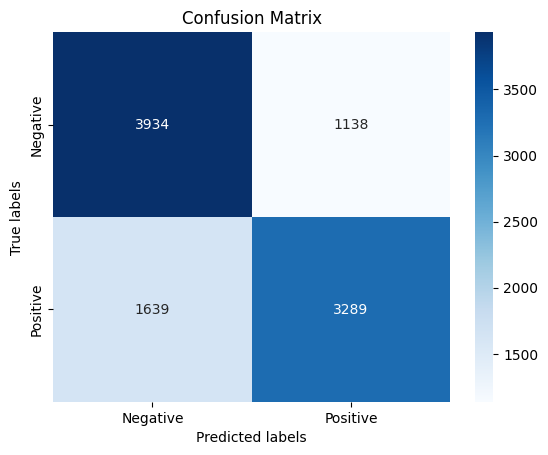

In [102]:
# 분류 성능 확인
predictions = np.array(pred1)
target_np = np.array(y_test)

# Data imbalance check
print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
print('-----------------------------------')

# metrics
accuracy = accuracy_score(target_np, predictions) # 정확도 계산
precision = precision_score(target_np, predictions) # 정밀도 계산
recall = recall_score(target_np, predictions) # 재현율 계산
f1 = f1_score(target_np, predictions) # F1 스코어 계산

print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')
print('-----------------------------------')

# confusion matrix
cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
fig, ax = plt.subplots() # 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()


In [140]:
# 백테스팅
transaction_fee = 0.005 / 100
returns = target_var[['returns_next10m', 'returns_next10m_binary']][split:] # test 실제 수익률
returns['pred'] = pred1 # 모델의 binary 예측값

# 거래 시뮬레이션: 예측이 1이면 구매하고, 아니면 거래하지 않음
simulated_returns = returns[returns['pred'] == 1]['returns_next10m'] - transaction_fee
total_return = simulated_returns.sum() # 총 수익
initial_investment = len(simulated_returns) # 투자 횟수
#final_portfolio_value = initial_investment + total_return # 최종 포트폴리오 가치

print(f"초기 투자 횟수: {initial_investment}")
print(f"총 수익: {total_return.round(4)}")
print(f"수익률: {(total_return / initial_investment * 100).round(4)}%")

초기 투자 횟수: 4427
총 수익: 1.663
수익률: 0.0376%
